# DOWNLOAD IMAGES USING AZURE IMAGES SEARCH API

In [1]:
from azure.cognitiveservices.search.imagesearch import ImageSearchClient
from msrest.authentication import CognitiveServicesCredentials
from fastbook import *
from utils import *
from fastai.vision.widgets import *

import os 

/home/mustafa/anaconda3/lib/python3.7/site-packages/fastbook/__init__.py:22: UserWarning: Missing `graphviz` - please run `conda install fastbook`
  except ModuleNotFoundError: warn("Missing `graphviz` - please run `conda install fastbook`")


# Get the key from your Azure acount 

In [2]:
key = os.environ.get('AZURE_SEARCH_KEY', 'Your Key')

# Using the func ... search_images_bing

In [3]:
search_images_bing

<function fastbook.search_images_bing(key, term, min_sz=128)>

# Download the Urls for the images 

In [4]:
results = search_images_bing(key, 'lion')
ims = results.attrgot('content_url')
len(ims)

150

# Plot some images 

In [5]:
ims[0]

'https://i.ytimg.com/vi/ePyKVhFyPC4/maxresdefault.jpg'

In [6]:
ims = ['https://i.ytimg.com/vi/ePyKVhFyPC4/maxresdefault.jpg']


In [7]:
dest = 'images/lion.jpg'
download_url(ims[0], dest)

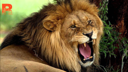

In [8]:
im = Image.open(dest)
im.to_thumb(128,128)

# Set the classes 

In [9]:
Feline = 'lion','tiger','leopard'
path = Path('Feline')

# Download the images for each class 
#### make sure that the dir is not there 

In [10]:
if not path.exists():
    path.mkdir()
    for o in Feline:
        dest = (path/o)
        dest.mkdir(exist_ok=True)
        results = search_images_bing(key, f'{o} Feline')
        download_images(dest, urls=results.attrgot('content_url'))

In [11]:
fns = get_image_files(path)
fns

(#295) [Path('Feline/lion/00000107.jpg'),Path('Feline/lion/00000138.jpg'),Path('Feline/lion/00000020.jpg'),Path('Feline/lion/00000042.png'),Path('Feline/lion/00000064.jpg'),Path('Feline/lion/00000104.jpg'),Path('Feline/lion/00000055.jpg'),Path('Feline/lion/00000026.jpg'),Path('Feline/lion/00000086.jpg'),Path('Feline/lion/00000016.jpg')...]

# Verify if there is no failed images 

In [12]:
failed = verify_images(fns)
failed

(#0) []

# Delete the failed images 

In [13]:
failed.map(Path.unlink);

In [14]:
class DataLoaders(GetAttr):
    def __init__(self, *loaders): self.loaders = loaders
    def __getitem__(self, i): return self.loaders[i]
    train,valid = add_props(lambda i,self: self[i])

In [15]:
Feline = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128))

In [16]:
get_items=get_image_files

In [17]:
splitter=RandomSplitter(valid_pct=0.2, seed=42)

In [18]:
get_y=parent_label

In [19]:
item_tfms=Resize(128)

In [20]:
dls = Feline.dataloaders(path)


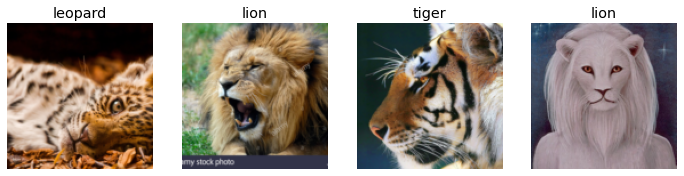

In [21]:
dls.valid.show_batch(max_n=4, nrows=1)

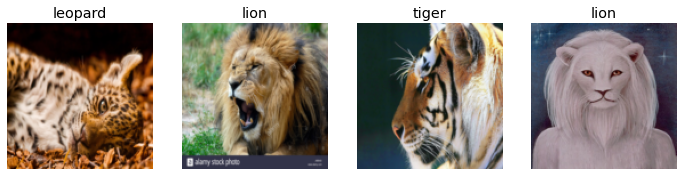

In [23]:
Feline = Feline.new(item_tfms=Resize(128, ResizeMethod.Squish))
dls = Feline.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

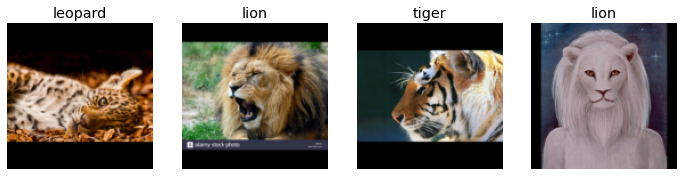

In [25]:
Feline = Feline.new(item_tfms=Resize(128, ResizeMethod.Pad, pad_mode='zeros'))
dls = Feline.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

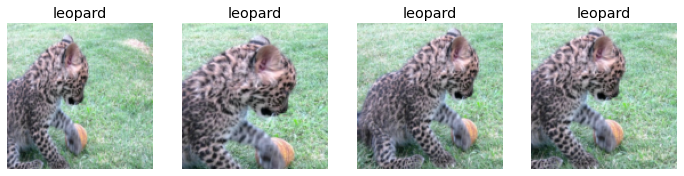

In [26]:
Feline = Feline.new(item_tfms=RandomResizedCrop(128, min_scale=0.3))
dls = Feline.dataloaders(path)
dls.train.show_batch(max_n=4, nrows=1, unique=True)

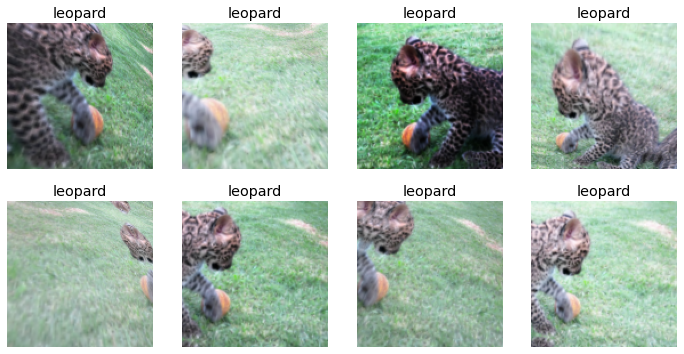

In [27]:
Feline = Feline.new(item_tfms=Resize(128), batch_tfms=aug_transforms(mult=2))
dls = Feline.dataloaders(path)
dls.train.show_batch(max_n=8, nrows=2, unique=True)

In [28]:
Feline = Feline.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms())
dls = Feline.dataloaders(path)

In [29]:
learn = cnn_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)

epoch,train_loss,valid_loss,error_rate,time
0,1.760848,0.854888,0.288136,00:06


epoch,train_loss,valid_loss,error_rate,time
0,0.709496,0.427188,0.152542,00:07
1,0.502319,0.262702,0.067797,00:07
2,0.361864,0.238453,0.033898,00:08
3,0.287693,0.241951,0.033898,00:07


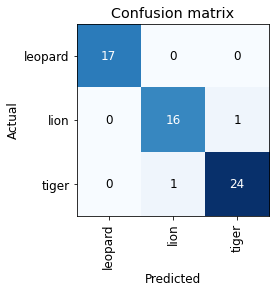

In [30]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

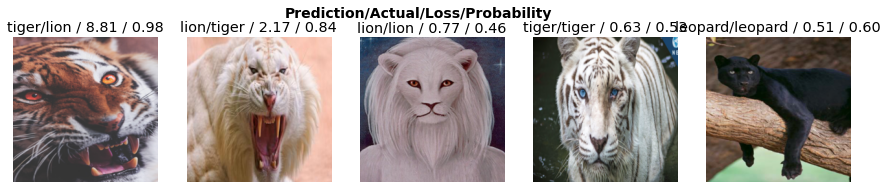

In [31]:
interp.plot_top_losses(5, nrows=1)


In [32]:
from fastai.vision.widgets import ImageClassifierCleaner
#hide_output
cleaner = ImageClassifierCleaner(learn)
cleaner

# Export the model and load it and test it 

In [33]:
learn.export()

In [34]:
path = Path()
path.ls(file_exts='.pkl')

(#1) [Path('export.pkl')]

In [35]:
learn_inf = load_learner(path/'export.pkl')

In [36]:
learn_inf.predict('images/lion.jpg')

('lion', tensor(1), tensor([2.8492e-07, 9.9920e-01, 7.9930e-04]))

In [37]:
learn_inf.dls.vocab

(#3) ['leopard','lion','tiger']

# Creating a Notebook App from the Model

In [38]:
btn_upload = widgets.FileUpload()
btn_upload

FileUpload(value={}, description='Upload')

In [40]:
img = PILImage.create(btn_upload.data[-1])

In [41]:
out_pl = widgets.Output()
out_pl.clear_output()
with out_pl: display(img.to_thumb(128,128))
out_pl

Output()

In [42]:
pred,pred_idx,probs = learn_inf.predict(img)

In [43]:
lbl_pred = widgets.Label()
lbl_pred.value = f'Prediction: {pred}; Probability:{probs[pred_idx]:.04f}'
lbl_pred

Label(value='Prediction: lion; Probability:0.9992')

In [44]:
btn_run = widgets.Button(description='Classify')
btn_run

Button(description='Classify', style=ButtonStyle())

In [45]:
def on_click_classify(change):
    img = PILImage.create(btn_upload.data[-1])
    out_pl.clear_output()
    with out_pl: display(img.to_thumb(128,128))
    pred,pred_idx,probs = learn_inf.predict(img)
    lbl_pred.value = f'Prediction: {pred}; Probability:{probs[pred_idx]:.04f}'
    
btn_run.on_click(on_click_classify)

In [46]:
btn_upload = widgets.FileUpload()


In [47]:
VBox([widgets.Label('Select your bear!'),
      btn_upload, btn_run, out_pl, lbl_pred])